# Decision trees

https://scikit-learn.org/stable/modules/tree.html

 * pruning: helps agains overfitting
 * decision trees within an ensemble $\rightarrow$ stability
 * balance data sets $\rightarrow$ else you get biased trees

## Initial example (from the scikit-learn website)

In [1]:
from pylab import *

In [13]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

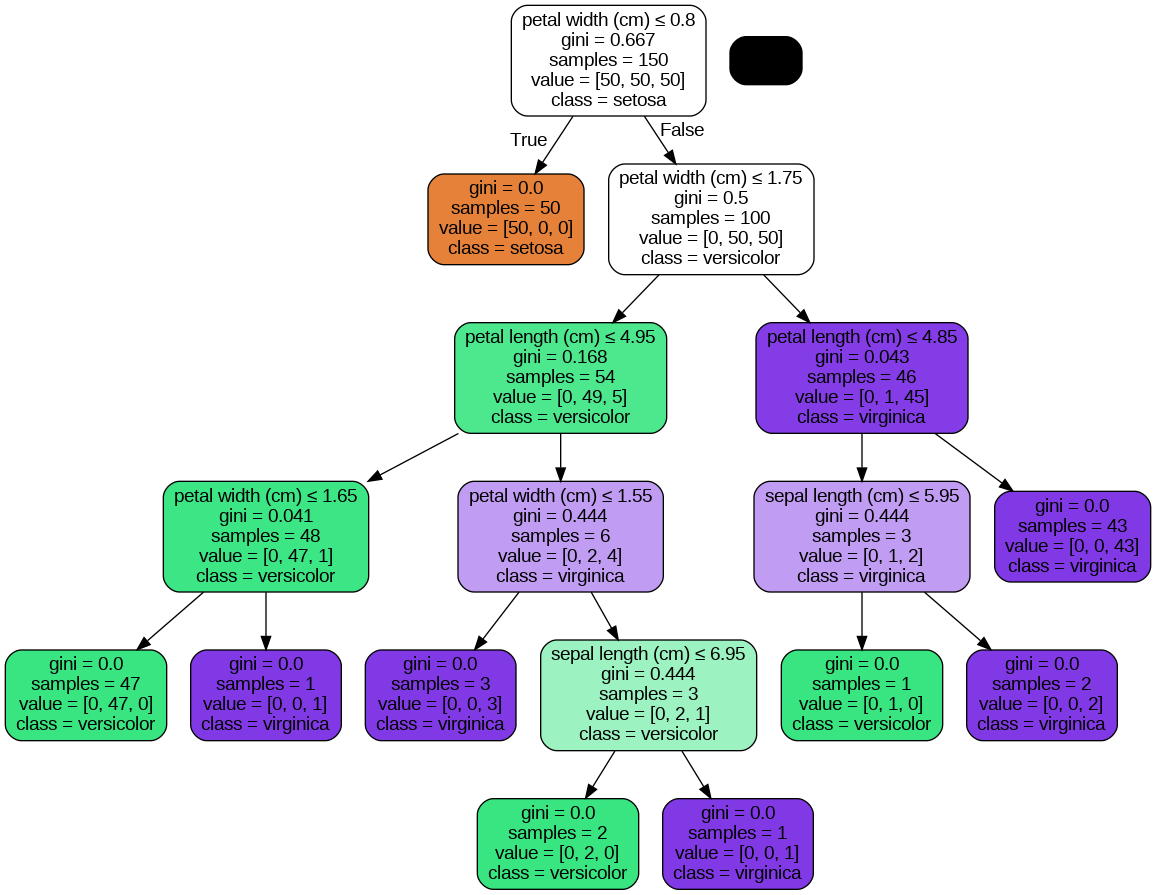

In [14]:
import graphviz, pydotplus
from IPython.display import Image  

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=iris.feature_names,  
                      class_names=iris.target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
Image(pydot_graph.create_png())

In [15]:
# adapted from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

def get_code(tree, feature_names):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, indent=0):
        if (right[node] != -1):
            assert left[node] != -1
            print(" "*indent + "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            recurse (left, right, threshold, features,left[node], indent+2)
            print(" "*indent + "} else {")
            recurse (left, right, threshold, features,right[node], indent+2)
            print(" "*indent + "}")
        else:
            print(" "*(indent) + "return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

get_code(clf,iris.feature_names)

if ( petal width (cm) <= 0.800000011920929 ) {
  return [[50.  0.  0.]]
} else {
  if ( petal width (cm) <= 1.75 ) {
    if ( petal length (cm) <= 4.950000047683716 ) {
      if ( petal width (cm) <= 1.6500000357627869 ) {
        return [[ 0. 47.  0.]]
      } else {
        return [[0. 0. 1.]]
      }
    } else {
      if ( petal width (cm) <= 1.550000011920929 ) {
        return [[0. 0. 3.]]
      } else {
        if ( sepal length (cm) <= 6.949999809265137 ) {
          return [[0. 2. 0.]]
        } else {
          return [[0. 0. 1.]]
        }
      }
    }
  } else {
    if ( petal length (cm) <= 4.8500001430511475 ) {
      if ( sepal length (cm) <= 5.950000047683716 ) {
        return [[0. 1. 0.]]
      } else {
        return [[0. 0. 2.]]
      }
    } else {
      return [[ 0.  0. 43.]]
    }
  }
}


In [39]:
from __future__ import annotations
import dataclasses
from typing import Union
import json

@dataclasses.dataclass
class LeafNode:
    class_idx: int
    probs: list[float]

@dataclasses.dataclass
class SplitNode:
    name: str
    idx: int
    threshold: float
    left: Union[SplitNode, LeafNode]
    right: Union[SplitNode, LeafNode]    
    
def get_decision_tree(tree, feature_names):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node):
        if (right[node] != -1):
            assert left[node] != -1
            return SplitNode(
                features[node],
                tree.tree_.feature[node],
                threshold[node],
                recurse (left, right, threshold, features,left[node]),
                recurse (left, right, threshold, features,right[node])
            )
        else:
            winner_idx = argmax(value[node])
            return LeafNode(
                winner_idx,
                value[node]
            )

    return recurse(left, right, threshold, features, 0)

class EnhancedJSONEncoder(json.JSONEncoder):
    # from https://stackoverflow.com/questions/51286748/make-the-python-json-encoder-support-pythons-new-dataclasses
    def default(self, o):
        if isinstance(o, np.ndarray):
            return o.tolist()        
        elif isinstance(o, np.integer):
            return int(o)
        elif isinstance(o, np.floating):
            return float(o)
        elif isinstance(o, np.floating):
            return float(o)
        elif dataclasses.is_dataclass(o):
            return dataclasses.asdict(o)
        else:
            return super().default(o)

t = get_decision_tree(clf,iris.feature_names)
print(json.dumps(t, cls=EnhancedJSONEncoder, indent=2))

{
  "name": "petal width (cm)",
  "idx": 3,
  "threshold": 0.800000011920929,
  "left": {
    "class_idx": 0,
    "probs": [
      [
        50.0,
        0.0,
        0.0
      ]
    ]
  },
  "right": {
    "name": "petal width (cm)",
    "idx": 3,
    "threshold": 1.75,
    "left": {
      "name": "petal length (cm)",
      "idx": 2,
      "threshold": 4.950000047683716,
      "left": {
        "name": "petal width (cm)",
        "idx": 3,
        "threshold": 1.6500000357627869,
        "left": {
          "class_idx": 1,
          "probs": [
            [
              0.0,
              47.0,
              0.0
            ]
          ]
        },
        "right": {
          "class_idx": 2,
          "probs": [
            [
              0.0,
              0.0,
              1.0
            ]
          ]
        }
      },
      "right": {
        "name": "petal width (cm)",
        "idx": 3,
        "threshold": 1.550000011920929,
        "left": {
          "class_idx": 2,
    

## Simple example problems

Define some problem sets:

In [5]:
%matplotlib inline
from pylab import *

def make_dataframe(**kwargs):
    from pandas import DataFrame
    return DataFrame(kwargs)

def my_plot_2D_data(D,T=None):
    if T is None:
        dataframe=D
    else:
        dataframe = make_dataframe( x=D[:,0], y=D[:,1], target=T )
    for target, data in dataframe.groupby("target"):
        plot(data.x, data.y, 'o', label=f"target={target}")
        
from sklearn.datasets import make_blobs, make_moons, make_circles

def my_make_blobs(n=2,a=3, xscale=1, yscale=1, xshift=0,nb_classes=2,n_samples=100):
    centers = [[0,0],[a,a],[a*2,0],[a,-a],
               [a,2*a]]
    D,T = make_blobs(
        n_samples=n_samples,
        centers=centers[0:n],
        cluster_std=1,
        n_features=2, 
        random_state=0
    )
    T = T%nb_classes
    return make_dataframe( x=D[:,0]*xscale+xshift, y=D[:,1]*yscale, target=T )

def my_circles():
    D,T = make_circles(
        n_samples=50,
        shuffle=True,
        noise=0.1,
        random_state=0, 
        factor=0.5
    )
    D2,T2 = make_circles(
        n_samples=100,
        shuffle=True,
        noise=0.05,
        random_state=0, 
        factor=0.5
    )
    D = concatenate((D,4*D2[T2==1,:]), axis=0)
    T = concatenate((T,T2[T2==1]), axis=0)
    return make_dataframe( x=D[:,0], y=D[:,1], target=T )

def my_make_moons():
    D,T = make_moons(
        n_samples=300, 
        shuffle=True,
        noise=0.2, 
        random_state=0
    )
    T = T%2
    return make_dataframe( x=D[:,0], y=D[:,1], target=T )

def make_challenge(level):
    if level==0: return my_make_blobs(2)
    elif level==1: return my_make_blobs(3)
    elif level==2: return my_make_blobs(4)
    elif level==3: return my_circles()
    elif level==4: return my_make_moons()
    raise Exception(f"unknown level f{level}")
    


### Show some challenges

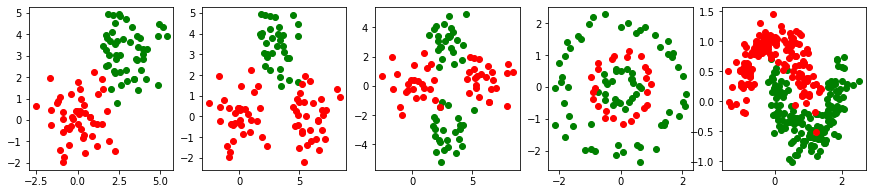

In [6]:
figure(figsize=[15,3])
N=5
idx=0
for n in range(N):
    idx += 1
    subplot(1,N,idx)
    dataframe = make_challenge(n)
    x = dataframe[["x"]].values.flatten()
    y = dataframe[["y"]].values.flatten()
    label = dataframe[["target"]].values.flatten()*2-1
    plot( x[label==+1], y[label==+1], 'go' )
    plot( x[label==-1], y[label==-1], 'ro' )

### Train and display classifier:

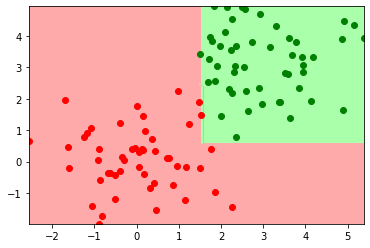

In [7]:
from sklearn.datasets import load_iris
from sklearn import tree

def train_and_show(model, dataframe):
    x = dataframe[["x"]].values.flatten()
    y = dataframe[["y"]].values.flatten()
    label = dataframe[["target"]].values.flatten()*2-1

    X_train = dataframe[["x","y"]].values
    y_train = dataframe[["target"]].values*2-1
    y_train = y_train.reshape(( len(y_train), ))
    model = model.fit(X_train, y_train)    
    
    N=100
    X,Y = meshgrid( linspace(min(x),max(x),N), linspace(min(y),max(y),N) )
    D = stack((X.flatten(), Y.flatten())).transpose()
    T = model.predict(D)
    #print(T.shape)

    T=T.flatten().reshape(X.shape)
    contourf(X,Y,sign(T),colors=['#FFAAAA','#AAFFAA'], extend=True)

    plot( x[label==+1], y[label==+1], 'go' )
    plot( x[label==-1], y[label==-1], 'ro' )
    
    
model = tree.DecisionTreeClassifier()
train_and_show(model, my_make_blobs(2));

### Example classification (simple decision tree)

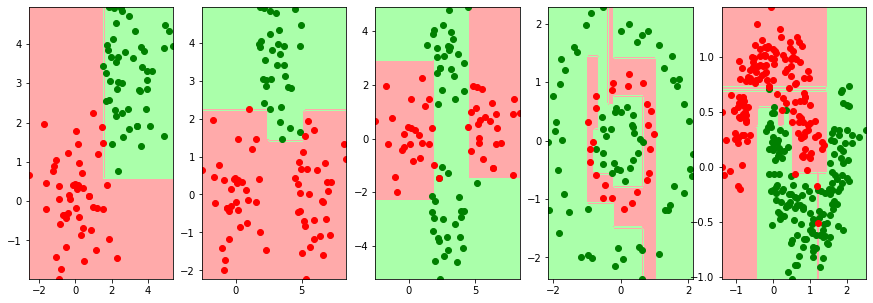

In [8]:
figure(figsize=[15,5])
N=5
idx=0
for n in range(N):
    idx += 1
    subplot(1,N,idx)
    model = tree.DecisionTreeClassifier(random_state=0)
    train_and_show(model, make_challenge(n))

## Random forests

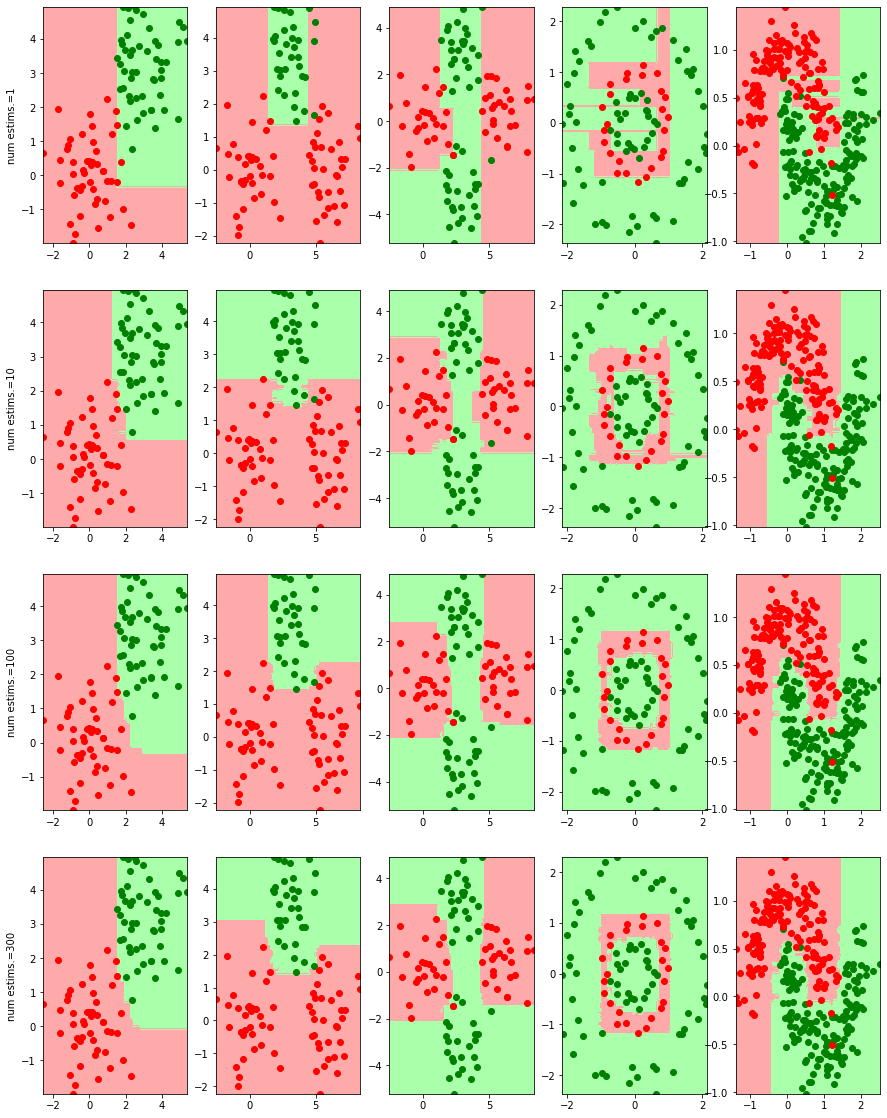

In [9]:
from sklearn.ensemble import RandomForestClassifier
N=5
idx=0
params=[1,10,100,300]
M=len(params)

figure(figsize=[15,5*M])
for m in range(M):   
    for n in range(N):
        if n==1:
            ylabel(f"num estims.={params[m]}")
        idx += 1
        subplot(M,N,idx)
        model = RandomForestClassifier(random_state=0, n_estimators=params[m])
        train_and_show(model, make_challenge(n))

## Pruning

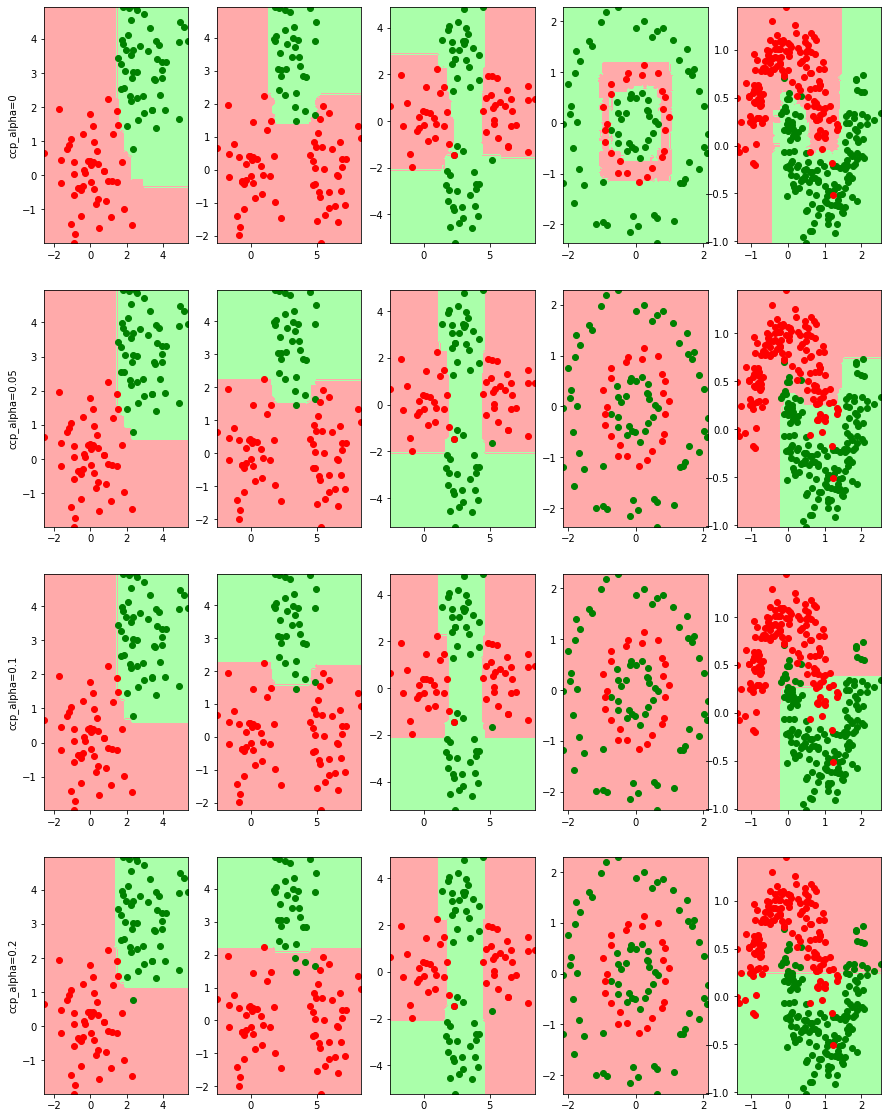

In [10]:
from sklearn.ensemble import RandomForestClassifier
N=5
idx=0
params=[0, 0.05, 0.1, 0.2]
M=len(params)

figure(figsize=[15,5*M])
for m in range(M):   
    for n in range(N):
        if n==1:
            ylabel(f"ccp_alpha={params[m]}")
        idx += 1
        subplot(M,N,idx)
        model = RandomForestClassifier(random_state=0, n_estimators=100, ccp_alpha=params[m])
        train_and_show(model, make_challenge(n))